<a href="https://colab.research.google.com/github/SANJAYV10/U_NET/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [3]:
! pip install kaggle

In [9]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
!  chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 712M/714M [00:36<00:00, 21.4MB/s]
100% 714M/714M [00:36<00:00, 20.5MB/s]


In [46]:
# ! unzip lgg-mri-segmentation

In [14]:
im_width = 256
im_height = 256

In [15]:
image_filenames_train = []

mask_files = glob('../content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

# print(image_filenames_train[:10])
len(image_filenames_train)

3929

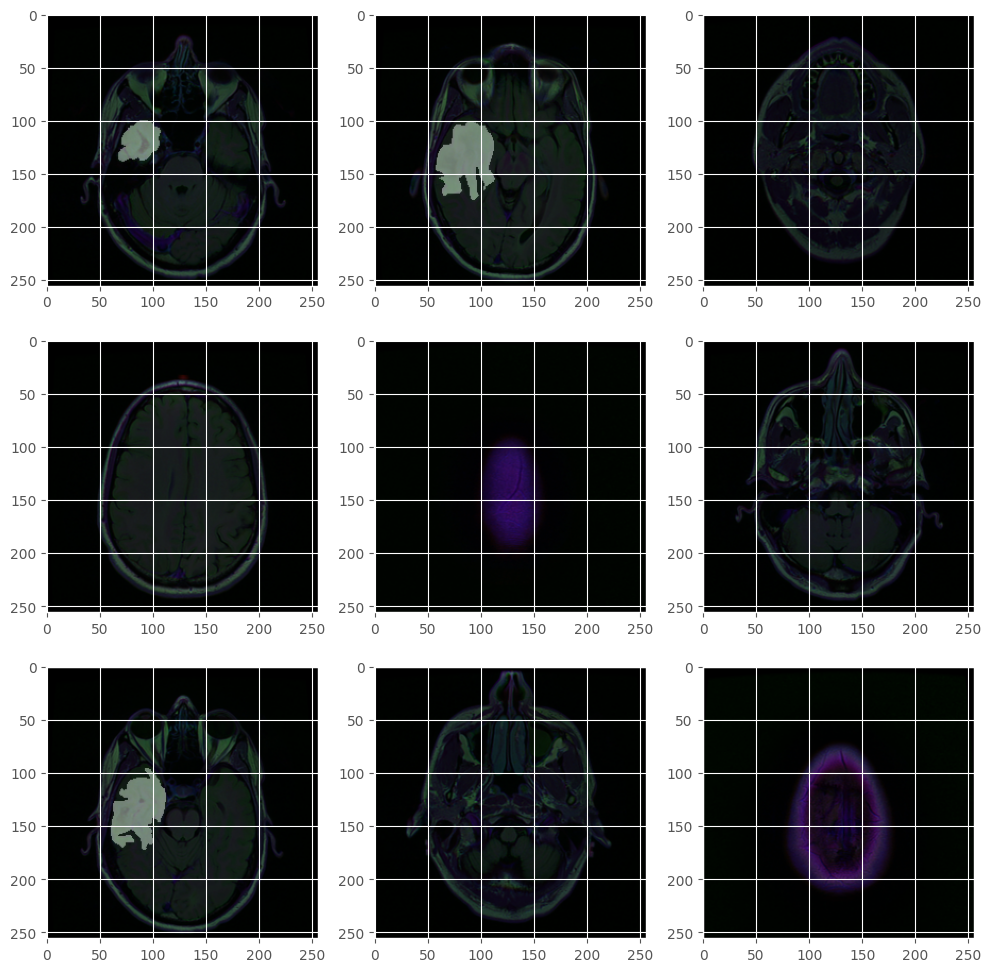

In [16]:
plot_from_img_path(3, 3 , image_filenames_train, mask_files )

In [17]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


# Data genertator, data augmentation and adjust data

In [18]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [19]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [20]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [21]:
model = unet()
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x795970127dc0>>

In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# ... (your previous code)

decay_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,  # Adjust this based on your dataset size and preference
    decay_rate=0.9  # Adjust this based on your preference
)

opt = Adam(learning_rate=decay_schedule, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])


In [23]:

# Define constants
im_height = 128
im_width = 128
BATCH_SIZE = 16
EPOCHS = 100
learning_rate = 1e-4

# Load and preprocess your data here
# df_train = ...
# df_val = ...

train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                            train_generator_param,
                            target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                            dict(),
                            target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))

decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,  # Adjust this based on your dataset size and preference
    decay_rate=0.9  # Adjust this based on your preference
)

opt = Adam(learning_rate=decay_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=test_gen,
                    validation_steps=len(df_val) // BATCH_SIZE)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: -0.1105 - binary_accuracy: 0.9169 - iou: 0.0606 - dice_coefficients: 0.1105Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02055, saving model to unet.hdf5
176/176 [==============================] - 75s 253ms/step - loss: -0.1105 - binary_accuracy: 0.9169 - iou: 0.0606 - dice_coefficients: 0.1105 - val_loss: -0.0206 - val_binary_accuracy: 0.9907 - val_iou: 0.0114 - val_dice_coefficients: 0.0206
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: -0.1841 - binary_accuracy: 0.9814 - iou: 0.1053 - dice_coefficients: 0.1840
Epoch 2: val_loss improved from -0.02055 to -0.06535, saving model to unet.hdf5
176/176 [==============================] - 51s 251ms/step - loss: -0.1841 - binary_accuracy: 0.9814 - iou: 0.1053 - dice_coefficients: 0.1840 - val_loss: -0.06

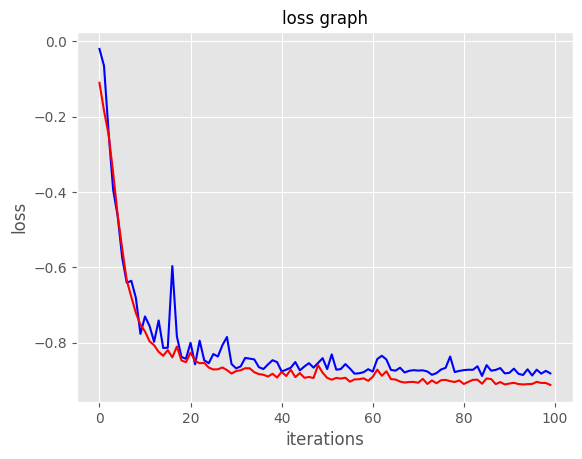

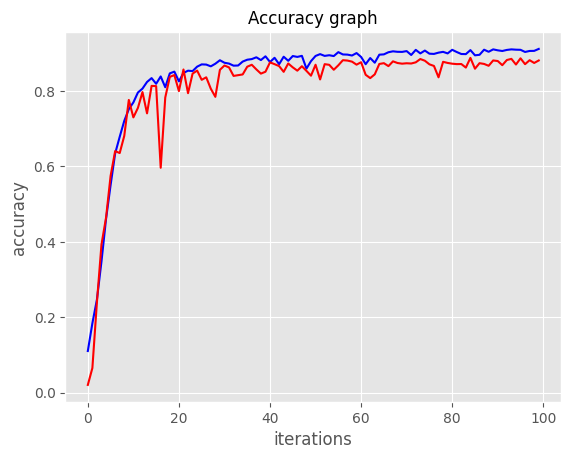

In [26]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

# Loading Pre-trained Model


In [41]:
from keras.models import load_model
from keras.utils import custom_object_scope
from utils import dice_coefficients_loss, iou, dice_coefficients

with custom_object_scope({
    'dice_coefficients_loss': dice_coefficients_loss,
    'iou': iou,
    'dice_coefficients': dice_coefficients
}):
    model = load_model('unet.hdf5')


In [42]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 6s 210ms/step - loss: -0.8816 - binary_accuracy: 0.9978 - iou: 0.8005 - dice_coefficients: 0.8815
Test Loss  -0.8815632462501526
Test IoU  0.9978167414665222
Test Dice Coefficient  0.8004749417304993


# Plotting Predicted Masks Segmentation results from the Test Image **set**

1/1 [==============================] - 0s 24ms/step


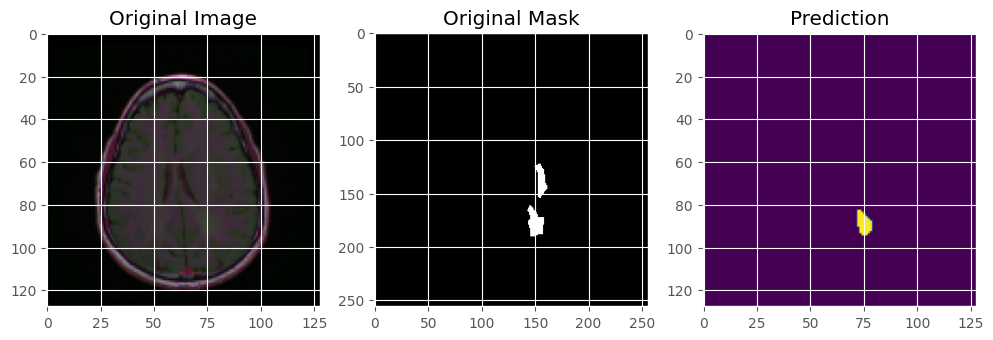

1/1 [==============================] - 0s 22ms/step


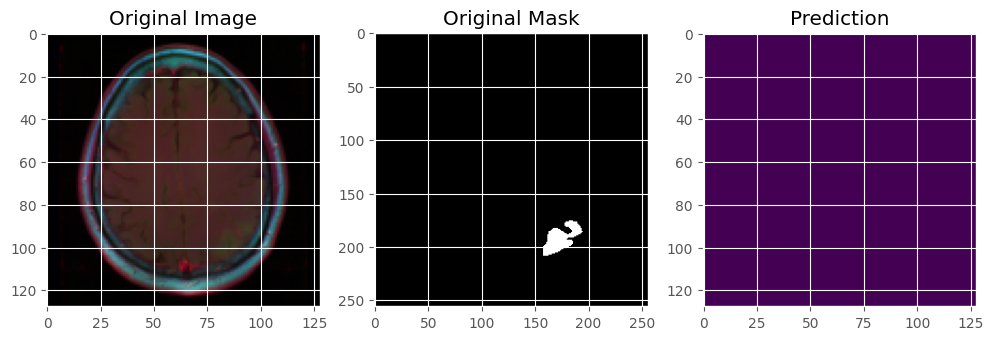

1/1 [==============================] - 0s 21ms/step


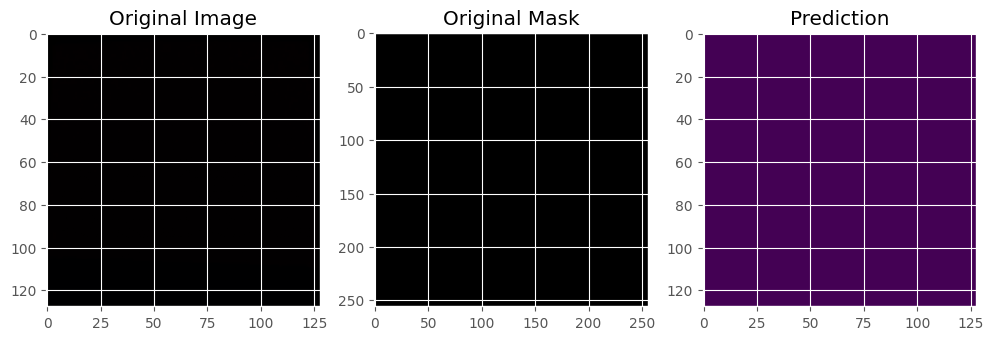

1/1 [==============================] - 0s 22ms/step


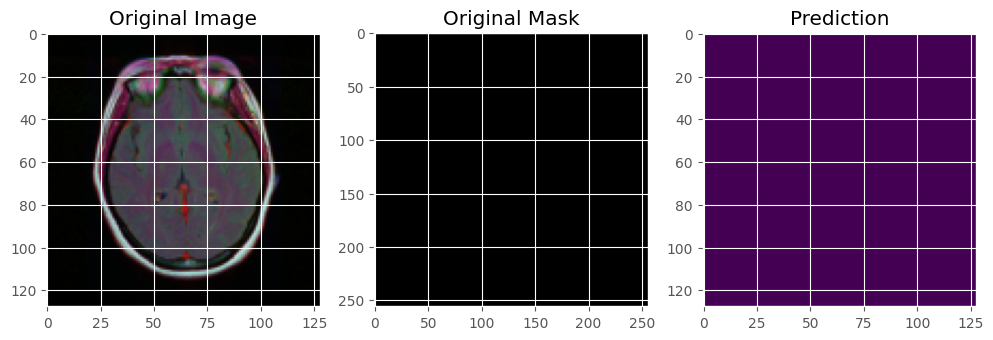

1/1 [==============================] - 0s 22ms/step


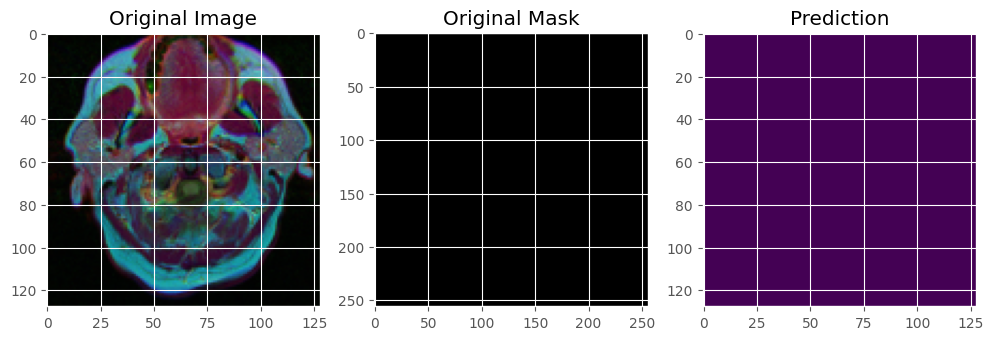

1/1 [==============================] - 0s 21ms/step


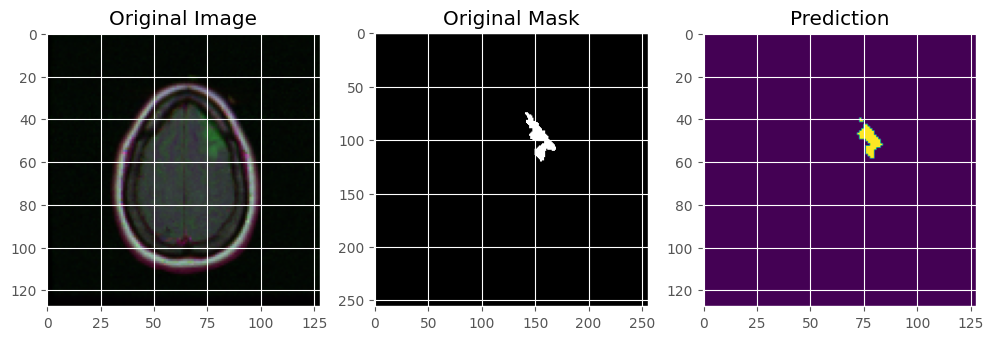

1/1 [==============================] - 0s 20ms/step


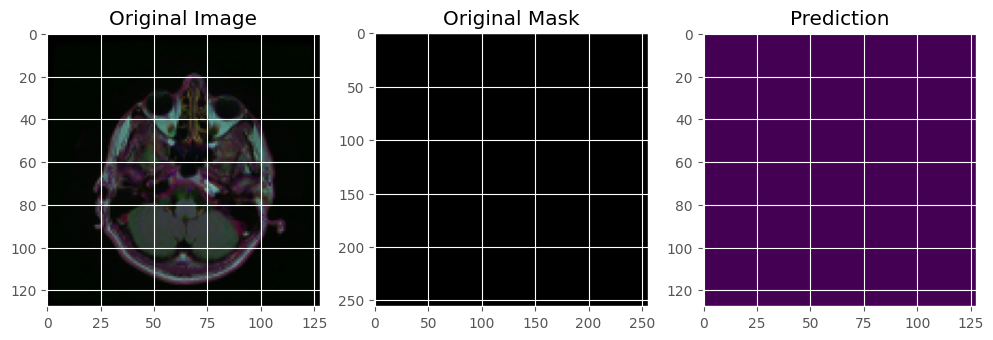

1/1 [==============================] - 0s 21ms/step


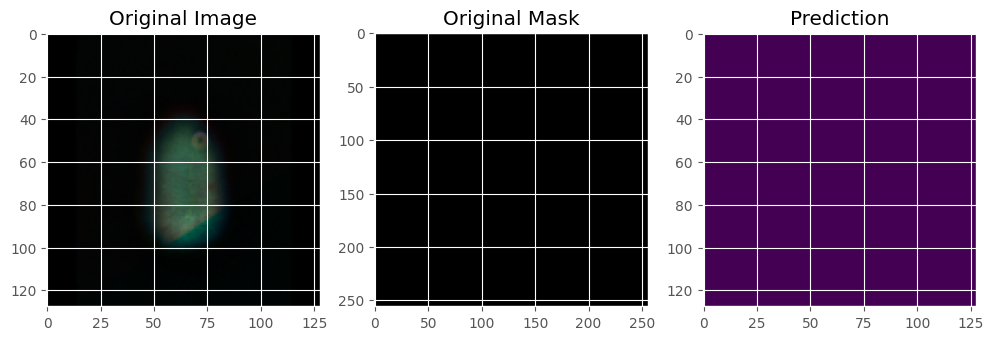

1/1 [==============================] - 0s 36ms/step


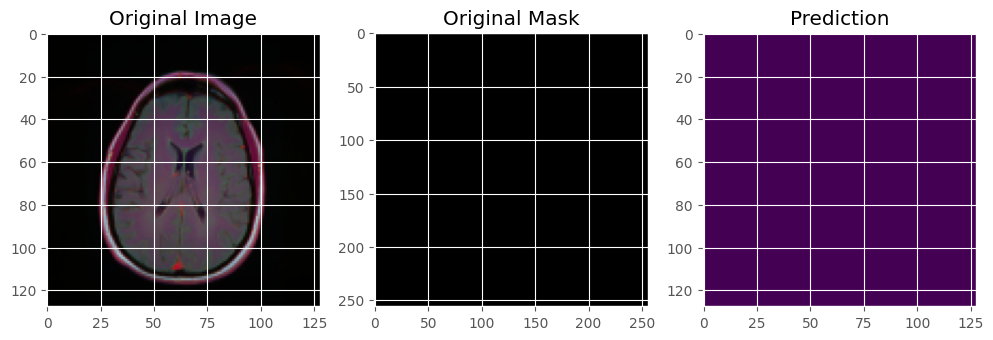

1/1 [==============================] - 0s 35ms/step


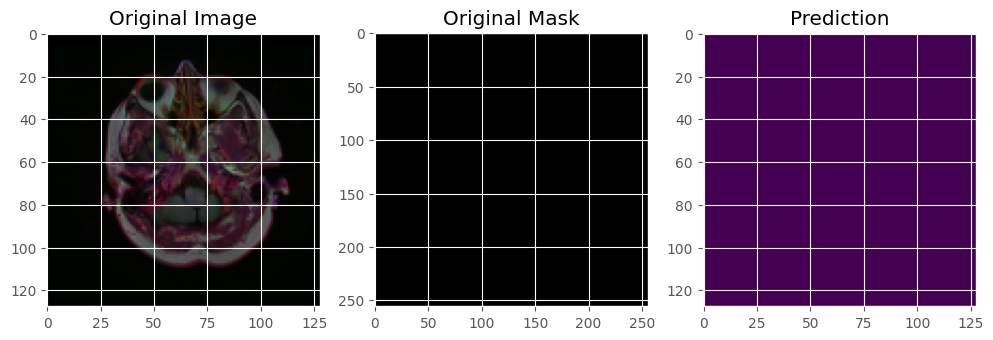

1/1 [==============================] - 0s 41ms/step


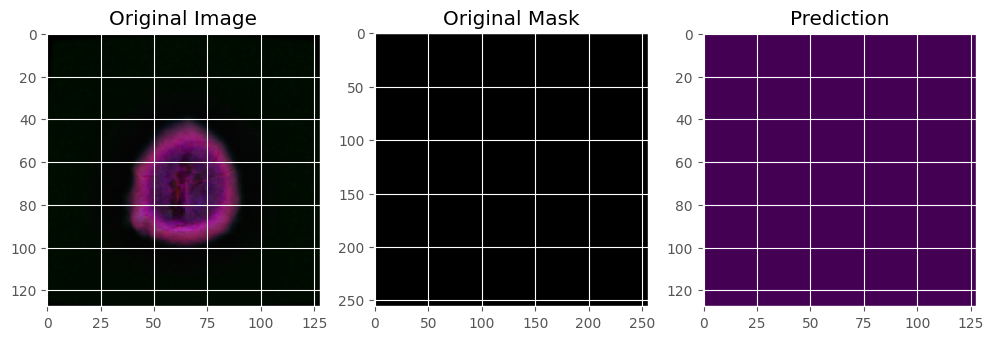

1/1 [==============================] - 0s 20ms/step


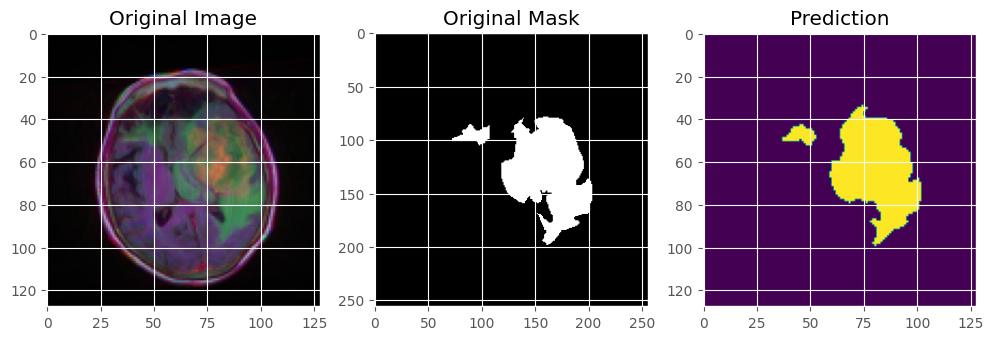

1/1 [==============================] - 0s 20ms/step


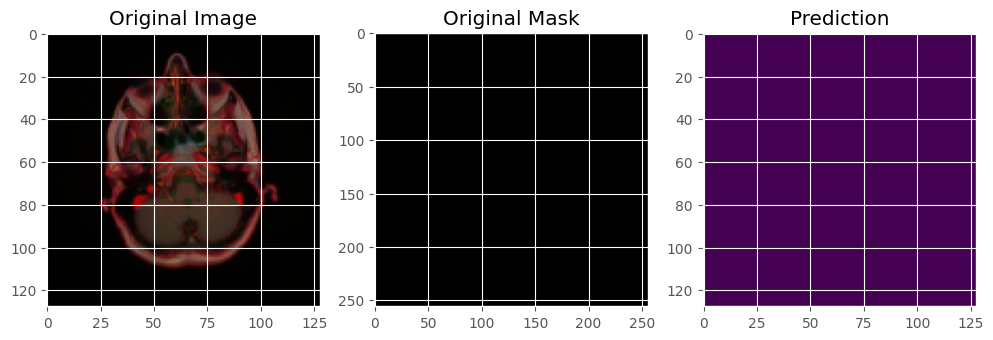

1/1 [==============================] - 0s 21ms/step


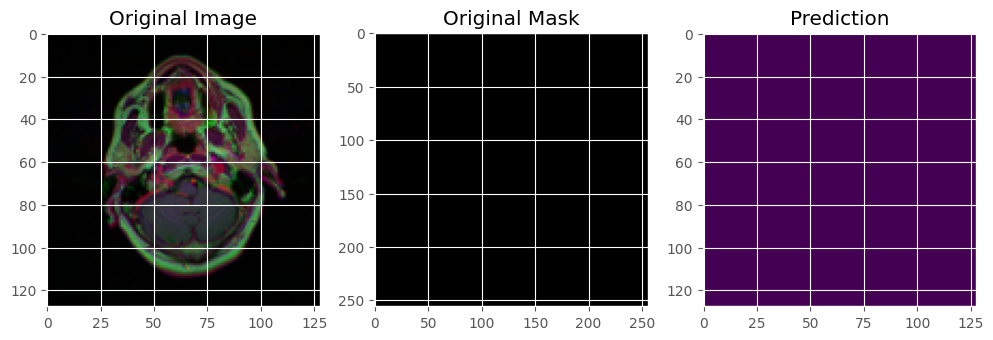

1/1 [==============================] - 0s 22ms/step


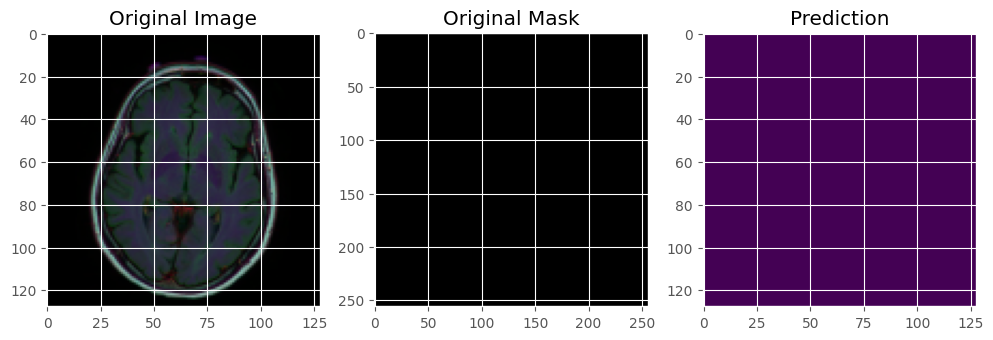

1/1 [==============================] - 0s 25ms/step


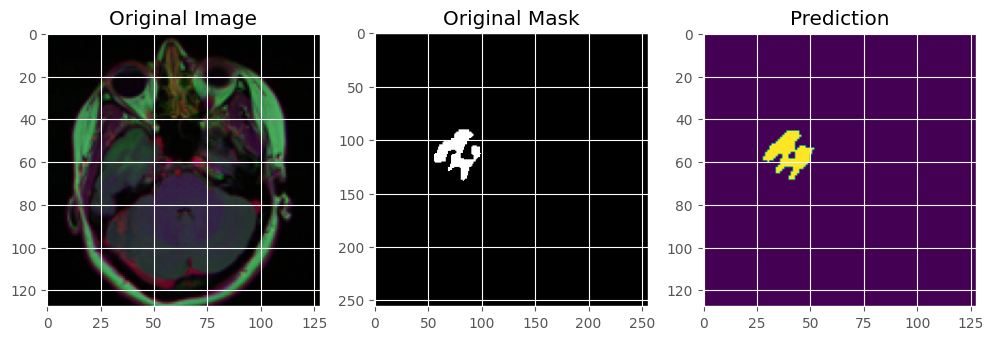

1/1 [==============================] - 0s 24ms/step


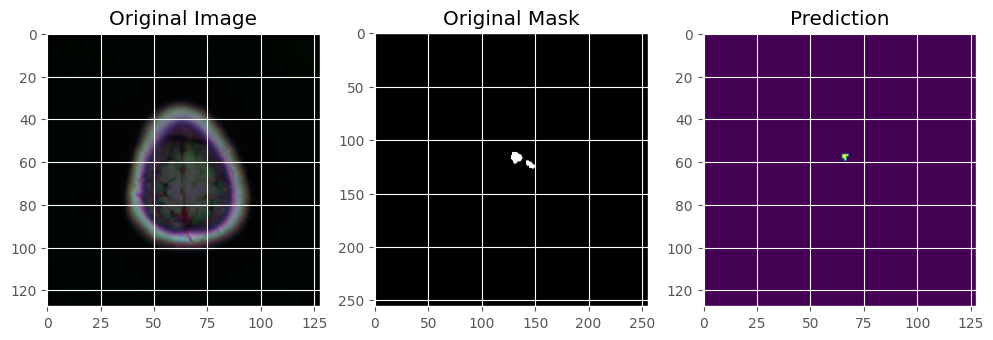

1/1 [==============================] - 0s 21ms/step


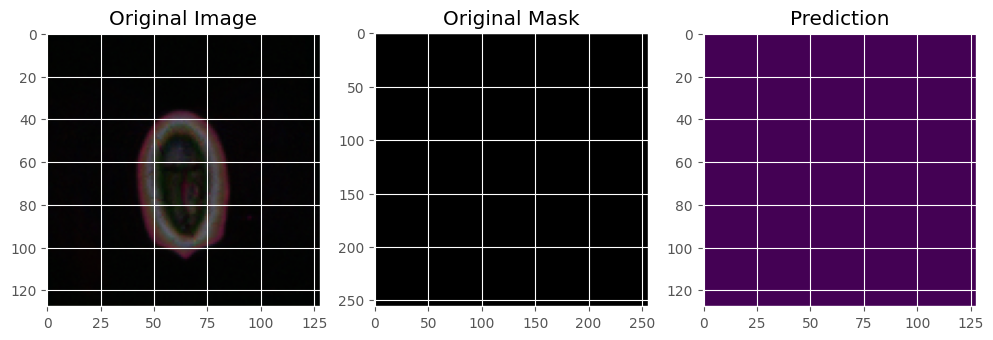

1/1 [==============================] - 0s 20ms/step


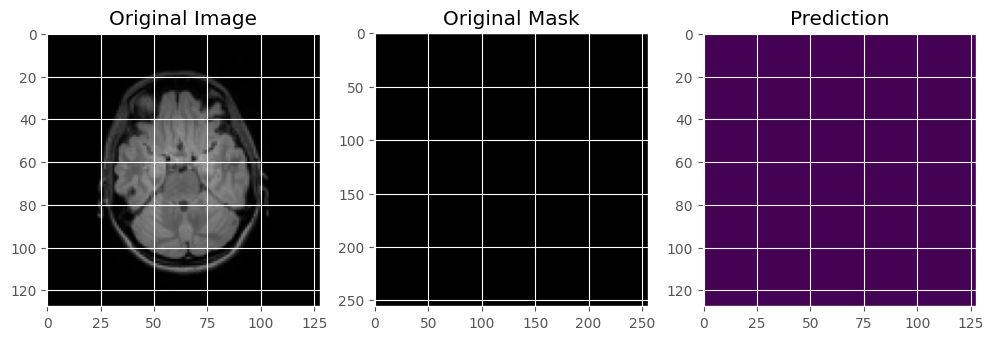

1/1 [==============================] - 0s 24ms/step


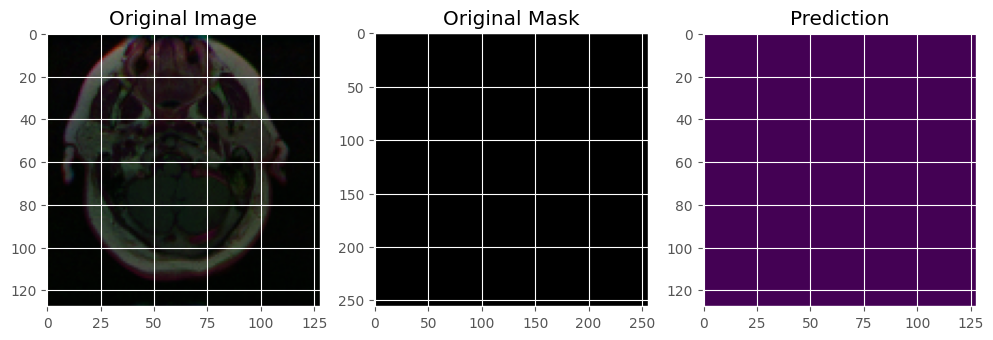

1/1 [==============================] - 0s 23ms/step


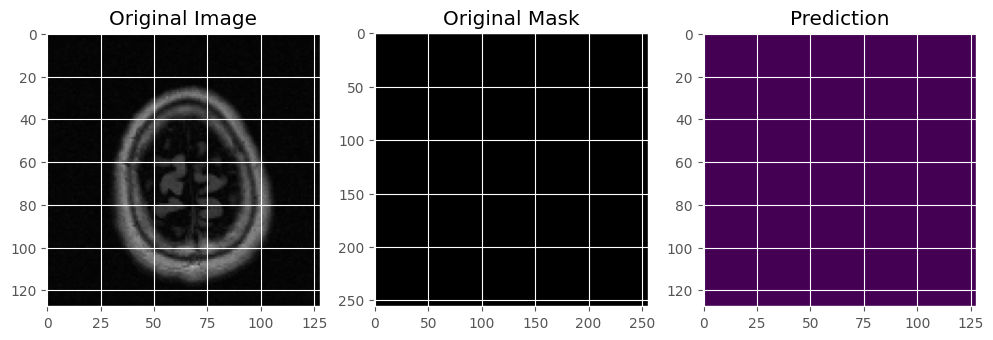

1/1 [==============================] - 0s 22ms/step


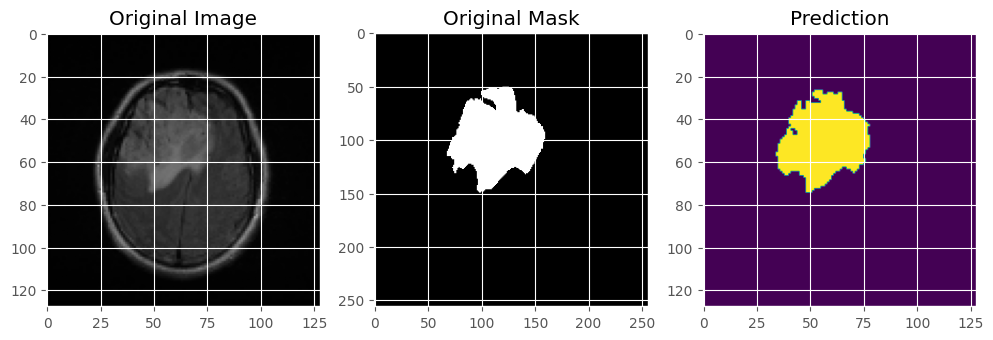

1/1 [==============================] - 0s 19ms/step


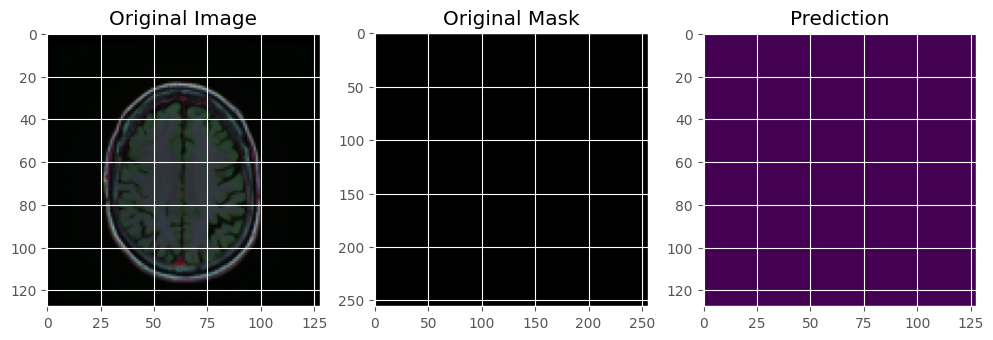

1/1 [==============================] - 0s 23ms/step


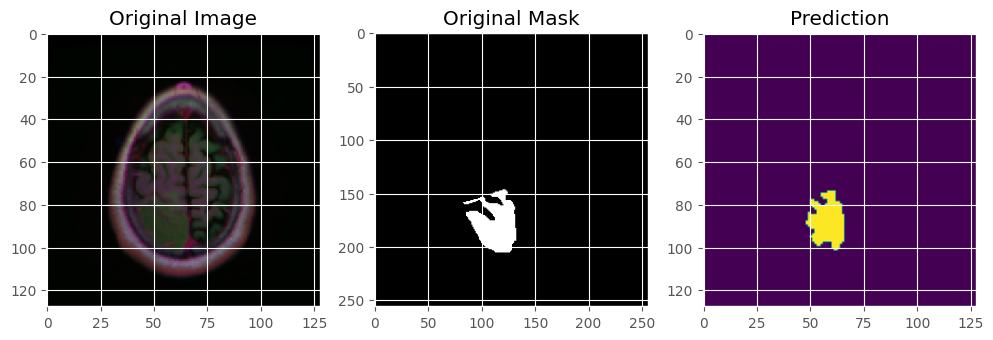

1/1 [==============================] - 0s 22ms/step


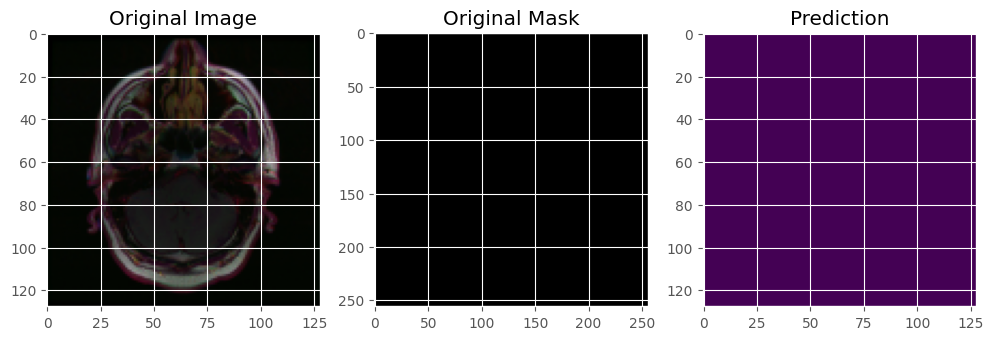

1/1 [==============================] - 0s 27ms/step


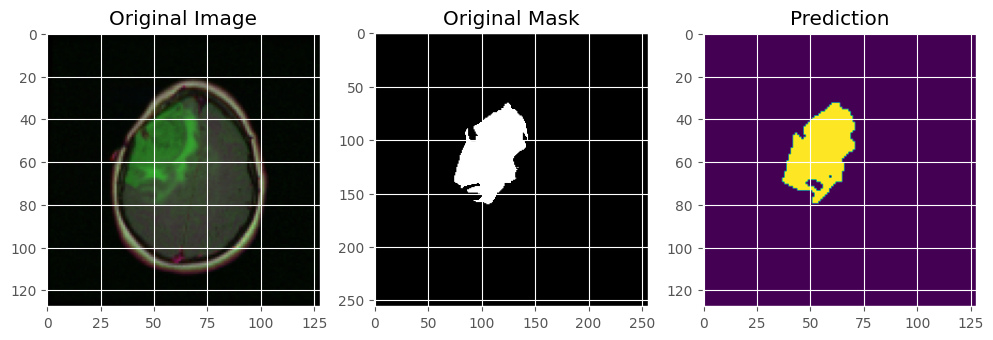

1/1 [==============================] - 0s 24ms/step


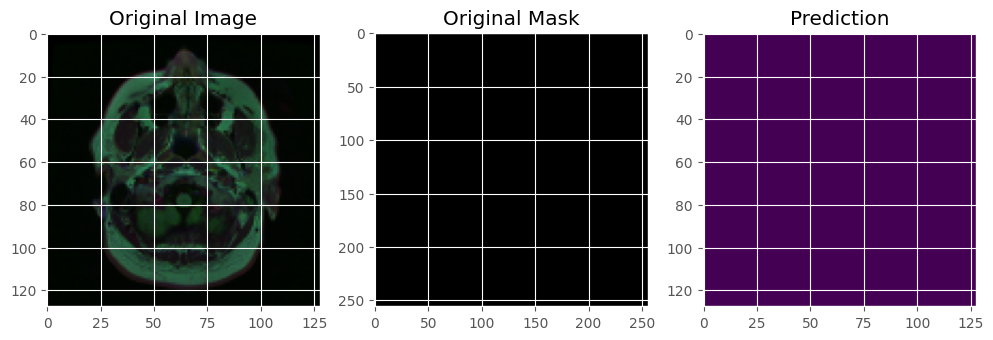

1/1 [==============================] - 0s 29ms/step


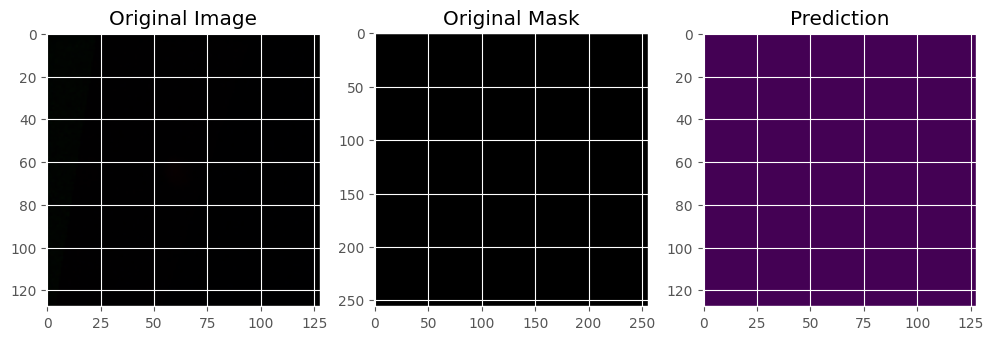

1/1 [==============================] - 0s 29ms/step


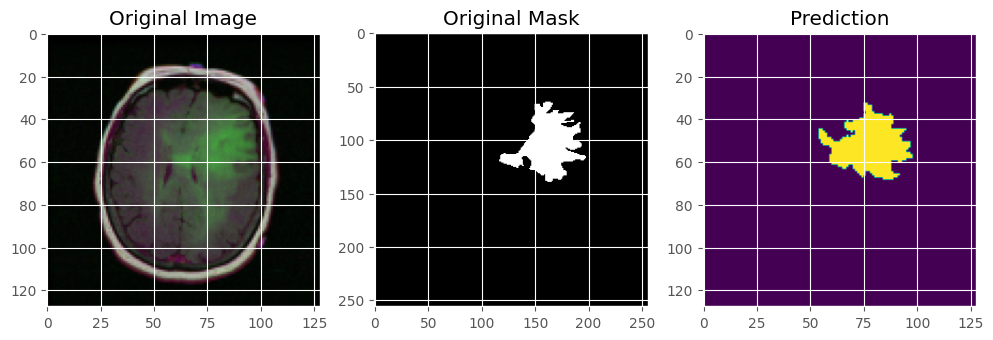

1/1 [==============================] - 0s 30ms/step


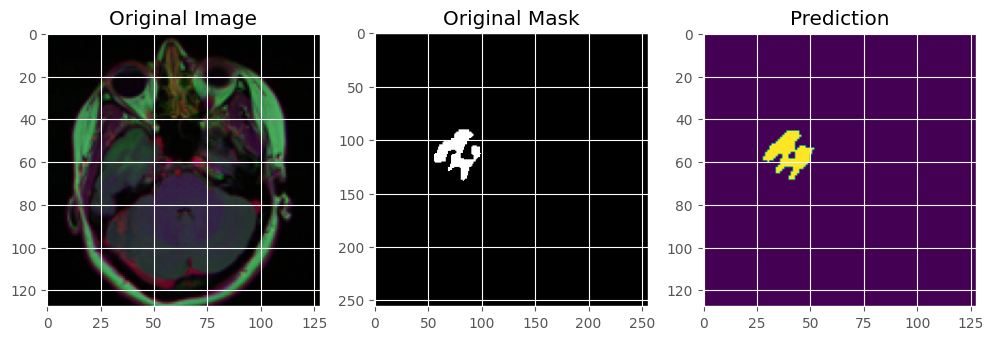

1/1 [==============================] - 0s 29ms/step


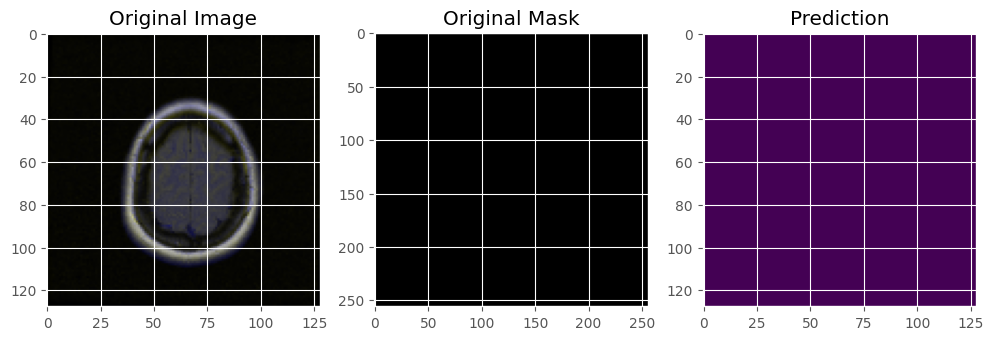

1/1 [==============================] - 0s 28ms/step


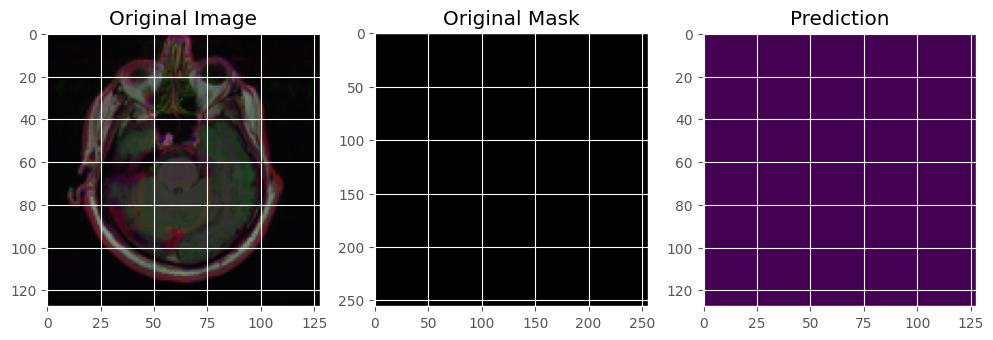

1/1 [==============================] - 0s 29ms/step


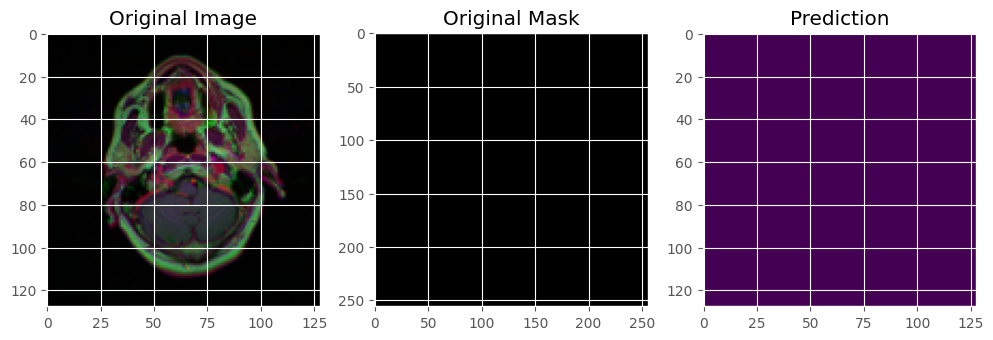

1/1 [==============================] - 0s 29ms/step


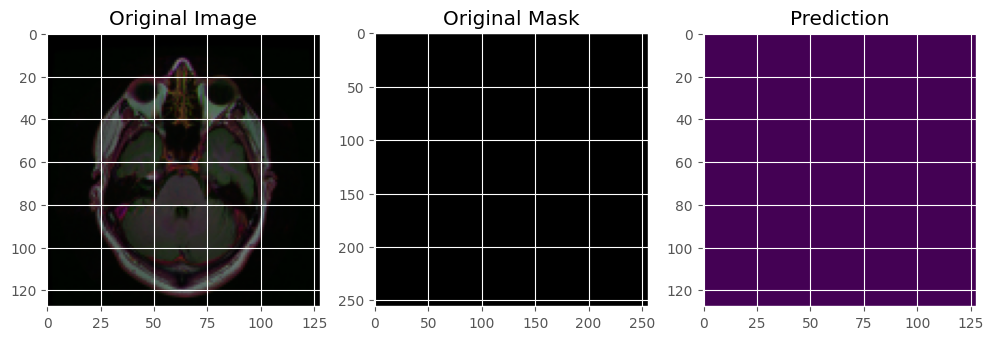

1/1 [==============================] - 0s 31ms/step


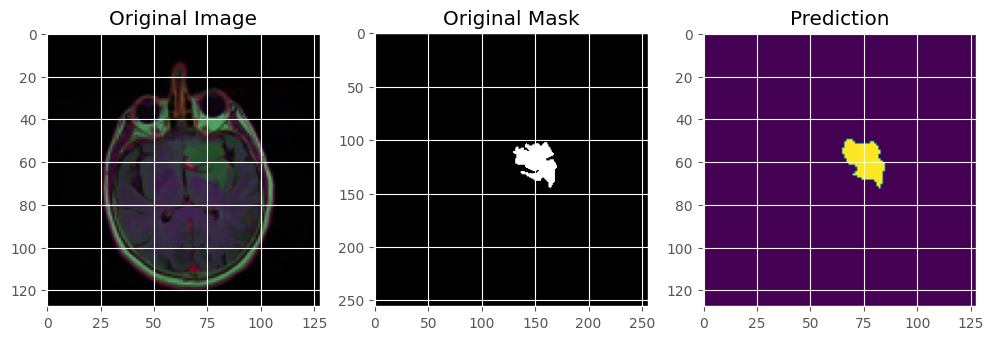

1/1 [==============================] - 0s 28ms/step


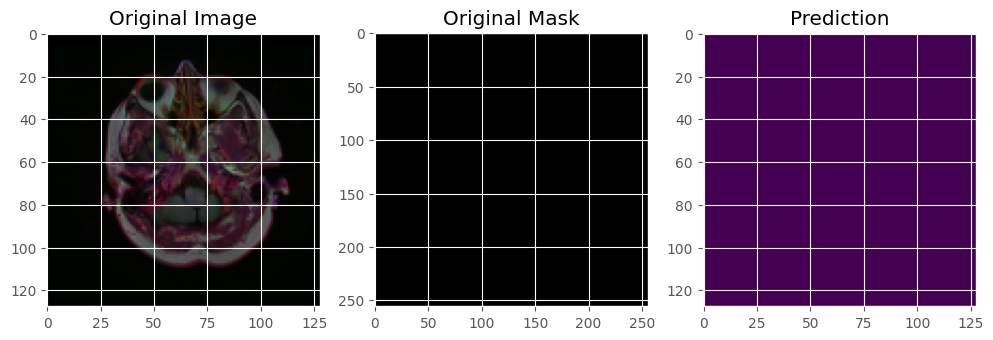

1/1 [==============================] - 0s 36ms/step


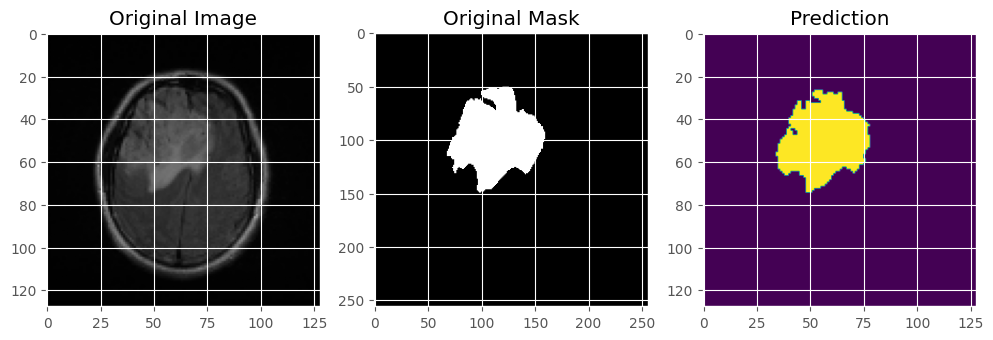

1/1 [==============================] - 0s 36ms/step


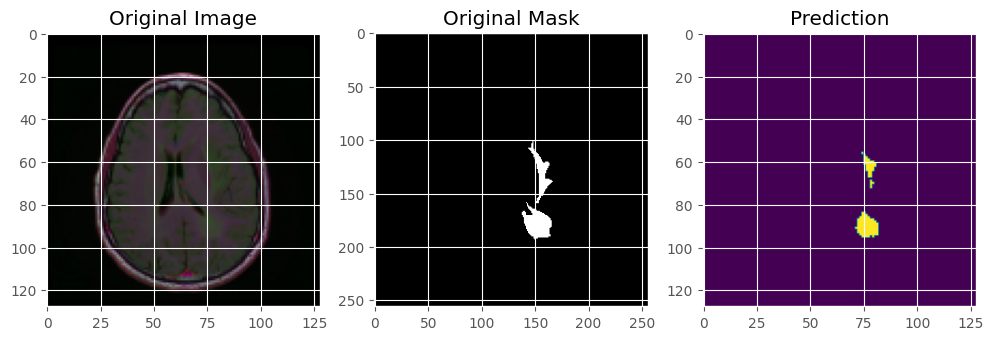

1/1 [==============================] - 0s 28ms/step


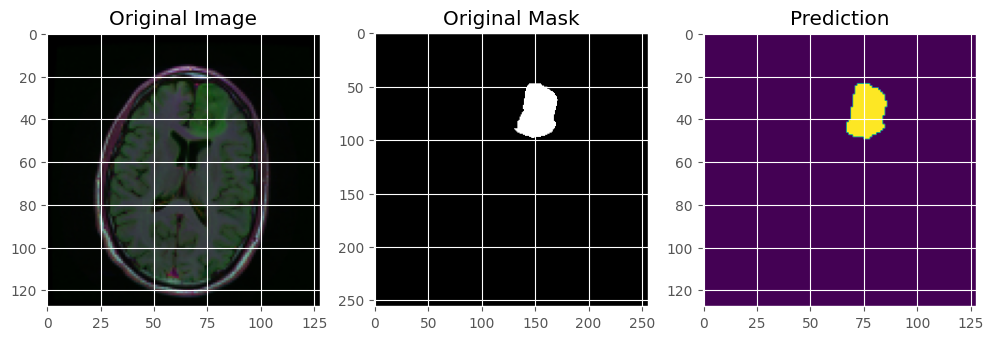

1/1 [==============================] - 0s 29ms/step


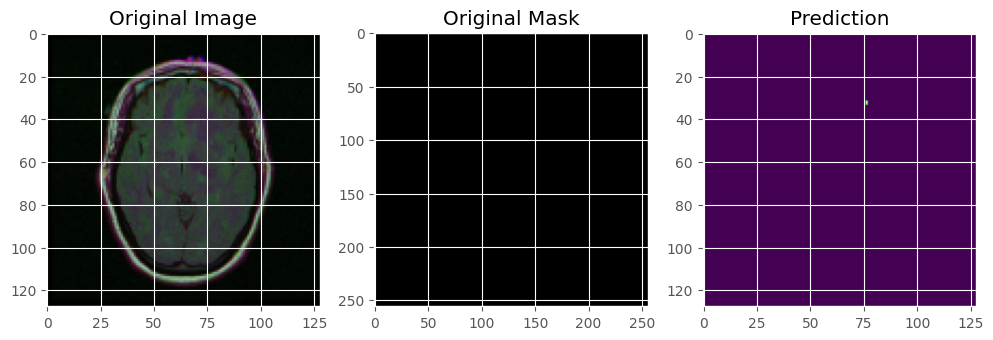

In [47]:
import numpy as np

for i in range(40):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()
